Have you ever struggled to differentiate between a bus and a tram and thought to your self wouldn't it be nice if I could just be able to identify them with a single image? Doesn't matter, I solve the problem anyways. Wouldn't it be dandy to have Deep Learning architecture which uses a pretrained model and as little as 60 images of each kind to make an image classification model. Here I explain the algorithm step-by-step for an absolute beginner to Machine Learning or Data Analysis! 

Let's dive right in!

First we make sure that the latest version of the libraries are installed with:

`!pip install -Uqq <libraries>` upgrades to the latest version of `<libraries>`

In [1]:
#to make sure all the latest versions of the libraries are installed

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

The next cell searches for images on duckduckgo.com and stores the result in the local hard drive.


In [4]:
from duckduckgo_search import ddg_images 
#fastcore adds "missing features" in python that it sees in other languages
from fastcore.all import *

#function that returns the urls of 30 images of the term variable from the duckduckgo search
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
#The function `search_image` gives urls of images in return we have convert them into images
urls = search_images('bus', max_images=1)
urls[0]

Searching for 'bus'


'https://humbernews.ca/wp-content/uploads/2019/06/DSC_4353-e1559667240877.jpg'

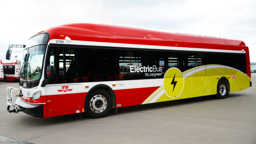

In [8]:
#This is to download the image from the url and the naming the image "bus.jpg"
from fastdownload import download_url
dest = 'bus.jpg'
download_url(urls[0], dest, show_progress=False)

#this is open the image and reshape it to 256 x 256
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Let's download and see an image of a tram.

Here `search_image` function searches duckduckgo for images of "tram" and the function `download_url` downloads the image and names it 'tram.jpg'

The last line opens the image and reshapes it.

Searching for 'tram'


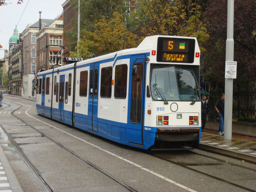

In [9]:
download_url(search_images('tram', max_images=1)[0], 'tram.jpg', show_progress=False)
Image.open('tram.jpg').to_thumb(256,256)

In [10]:
searches = 'tram','bus'
path = Path('bus_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} new'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'tram'
Searching for 'tram new'
Searching for 'bus'
Searching for 'bus new'


# Training the model 

In [11]:
#To remove the images that didnt get downloaded properly

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

17

To train the model we use `DataBlock`. Think of it as a way to mention all the settings of the model. Here we have:

* `blocks=(ImageBlock, CategoryBlock)` - We are mentioning that the input will be images abd the output is a category

* `get_items=get_image_files` - It tells the model where to get the input from. `get_image_files` is a function which returns a list of the image files in the path

* `splitter=RandomSplitter(valid_pct=0.2, seed=42)` This randomly splits the data. 80% is used as training data and 20% is used as validation data.

* `get_y=parent_label` It tells the model that the ground truth (the actual labels for the input) are the `parent` of each file. Here it is the name of the images.

* `item_tfms=[Resize(192, method='squish')]` resizes the images to 192x192 pixels by squishing them.

The `dataloader` is an object that contains the training data and the validation data.

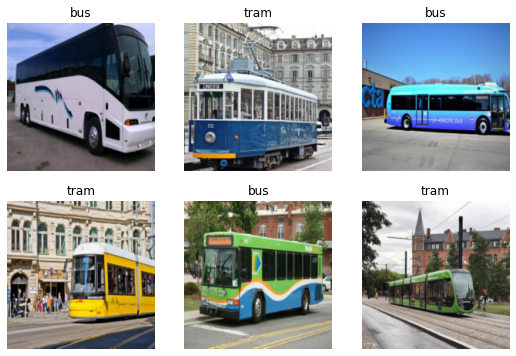

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we train our model!

We are going to use `resnet18`. Resnet18 is a pretrained neural network model. Let's break that down, how does having a pretrained model help us?

Pretrained models have found the best parameters to use. What we are doing is importing this model and then working on it with our data and specifications (the ones in the DataBlock). Normally when we start training a model, we initiallise all the parameters to random values and then with each epoch we work on making them slightly better but with pretrained models we start with some really good parameters and see how we can make them better for your data.

In [13]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mendu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.930093,0.258470,0.100000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.459180,0.231166,0.100000,00:03
1,0.354018,0.109868,0.000000,00:03
2,0.288311,0.117176,0.100000,00:03
3,0.223806,0.106010,0.050000,00:03
4,0.192303,0.130990,0.050000,00:03


`fastai` has the method `fine_tune` which automatically uses the best methods to fine-tune the parameters

# Finding out if its a bus or a tram?

In [14]:
is_bus,_,probs = learn.predict(PILImage.create('bus.jpg'))
print(f"This is a: {is_bus}.")
print(f"Probability it's a bus: {probs[0]:.4f}")

This is a: bus.
Probability it's a bus: 0.9997


Tada! When presented with an image of a bus that the model has not seen before, it predicts it as a bus correctly and with 100% accuracy (well almost!).

### Refernces:

This article was inspired by Lesson 1 in the fastai course "Practical Deep Learning". Here is a link to the course material: https://course.fast.ai/